In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine, load_iris
import random
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.datasets._samples_generator import make_blobs
import math
from typing import Callable, List
import copy
from scipy.spatial import distance

In [2]:
#data, labels = load_digits(return_X_y=True)
#data, labels = load_wine(return_X_y=True)
data, labels = load_iris(return_X_y=True)
(n_samples, n_features), n_clusters = data.shape, np.unique(labels).size

#centers = [[10, 10, 10], [-10, -10, 0], [10, -10, 10]]
#n_clusters = len(centers)
#X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=2)

#n_digits = n_clusters

In [3]:
import math
from typing import Callable
import copy

def eucledian_dist(point0, point1):
    dist = 0.0
    for i in range(0,len(point0)):
        dist += (point0[i] - point1[i])**2
    return math.sqrt(dist)

class Particle:
    """
    Represents one solution for clustering, represented by their centroids.
    """
    def __init__(self, 
                 k: int,
                 points: list,
                 distance: Callable,
                 objective: Callable,
                 w: float,
                 c1: float,
                 c2:float,
                 bounds: tuple):
        self.k = k
        self.points = points
        self.velocity = [[random.uniform(bounds[0], bounds[1]) for _ in range(len(points[0]))] for _ in range(k)]
        self.objective = objective
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.centroids = random.sample(points, k)
        self.distance = distance
        
        self.bestPosition = copy.deepcopy(self.centroids)
        self.currentValue = objective(points, self._assign_clusters(points))
        self.bestValue = self.currentValue
        self.bounds = bounds
        
    def _assign_clusters(self, points):
        """
        Assign clusters to each point as nearest (based on distance) centroid
        """
        clusters = []
        for point in points:
            clusters.append(self.centroids.index(min(self.centroids, key=lambda x: self.distance(point, x))))
        return clusters
    
    def updatePosition(self, globalBestPosition, globalBestValue, globalBestParticle):
        
        for i in range(len(self.centroids)):
            for j in range(len(self.centroids[i])):
                self.centroids[i][j] += self.velocity[i][j]
                
        
        self.currentValue = self.objective(self.points, self._assign_clusters(self.points))
        if self.currentValue < self.bestValue:
            self.bestValue = self.currentValue
            self.bestPosition = copy.deepcopy(self.centroids)
            
            if self.currentValue < globalBestValue:
                globalBestValue = self.currentValue
                globalBestPosition = copy.deepcopy(self.centroids)
                globalBestParticle = copy.deepcopy(self)
                
        return globalBestPosition, globalBestValue, globalBestParticle
            
            
    def updateVelocity(self, globalBestPosition):
        r1 = random.random()
        r2 = random.random()
        for i in range(len(self.velocity)):
            for j in range(len(self.velocity[i])):
                cognitive_velocity = r1 * self.c1 * (self.bestPosition[i][j] - self.centroids[i][j])
                social_velocity = r2 * self.c2 * (globalBestPosition[i][j] - self.centroids[i][j])
            
                self.velocity[i][j] = self.w * self.velocity[i][j] + cognitive_velocity + social_velocity  
                if self.velocity[i][j] > self.bounds[1]:
                    self.velocity[i][j] = self.bounds[1]
                elif self.velocity[i][j] < self.bounds[0]:
                    self.velocity[i][j] = self.bounds[0]
        

In [4]:
class PSO:
    def __init__(self,
                k: int,
                data: list,
                distance: Callable[[List[float], List[float]], float],
                objective: Callable[[List[float], List[float]], float],
                w: float,
                c1: float,
                c2: float):
        pass
                
        

In [5]:
SWARM_SIZE = 20
MAX_ITER = 500
bounds = (-2, 2)
print(data.shape)

swarm = [Particle(n_clusters, data.tolist(), eucledian_dist, davies_bouldin_score, 0.75, 1, 1, bounds) for _ in range(SWARM_SIZE)]

def chs_inverted(points, clusters):
    return -calinski_harabasz_score(points, clusters)

#swarm = [Particle(n_clusters, data.tolist(), eucledian_dist, chs_inverted, 0.75, 1, 2, bounds) for _ in range(SWARM_SIZE)]
globalBestPosition = copy.deepcopy(swarm[0].centroids)
globalBestValue = swarm[0].currentValue
globalBestParticle = swarm[0]
#plt.scatter(data[:, 0], data[:, 1], c = globalBestParticle._assign_clusters(data.tolist()))
#centroids_np = np.array(globalBestParticle.centroids)
#plt.scatter(centroids_np[:, 0], centroids_np[:, 1], color='orange')

for particle in swarm:
    if particle.currentValue < globalBestValue:
        globalBestValue = particle.currentValue
        globalBestPosition = copy.deepcopy(particle.centroids)
        globalBestParticle = particle


bests = []
for i in range(MAX_ITER):
    for j in range(len(swarm)):
        swarm[j].updateVelocity(globalBestPosition)
        globalBestPosition, globalBestValue, globalBestParticle = swarm[j].updatePosition(globalBestPosition, globalBestValue, globalBestParticle)
        
    bests.append(globalBestValue)
    print("{}/{}, best: {}".format(i, MAX_ITER, globalBestValue))

#print('Solution: {}, value: {}'.format(globalBestPosition, globalBestValue))
print(globalBestValue)
clusters = globalBestParticle._assign_clusters(data.tolist())
print(set(clusters))
print(davies_bouldin_score(data.tolist(), clusters))
print(davies_bouldin_score(globalBestParticle.points, clusters))

(150, 4)
0/500, best: 0.3392983056960975
1/500, best: 0.3180967942559718
2/500, best: 0.3139861360204727
3/500, best: 0.30477621825897416
4/500, best: 0.3035587463430515
5/500, best: 0.300804411267295
6/500, best: 0.300804411267295
7/500, best: 0.3002144215320243
8/500, best: 0.29850097097828904
9/500, best: 0.29633868064971336
10/500, best: 0.29417504714013015
11/500, best: 0.29148516758342846
12/500, best: 0.29038324853526537
13/500, best: 0.2882472082644016
14/500, best: 0.28534672320536747
15/500, best: 0.28534672320536747
16/500, best: 0.2849563472306314
17/500, best: 0.2845999280570856
18/500, best: 0.28426423303153187
19/500, best: 0.28426423303153187
20/500, best: 0.28426423303153187
21/500, best: 0.2842358152480351
22/500, best: 0.2842358152480351
23/500, best: 0.2842358152480351
24/500, best: 0.2842358152480351
25/500, best: 0.2842358152480351
26/500, best: 0.2842358152480351
27/500, best: 0.28423248252505756
28/500, best: 0.28423248252505756
29/500, best: 0.2842316126571891


242/500, best: 0.2813895527490163
243/500, best: 0.2813895527490163
244/500, best: 0.2813895527490163
245/500, best: 0.2813895527490163
246/500, best: 0.2813895527490163
247/500, best: 0.2813895527490163
248/500, best: 0.2813895527490163
249/500, best: 0.2813895527490163
250/500, best: 0.2813895527490163
251/500, best: 0.2813895527490163
252/500, best: 0.2813895527490163
253/500, best: 0.2813895527490163
254/500, best: 0.2813895527490163
255/500, best: 0.2813895527490163
256/500, best: 0.2813895527490163
257/500, best: 0.2813895527490163
258/500, best: 0.2813895527490163
259/500, best: 0.2813895527490163
260/500, best: 0.2813895527490163
261/500, best: 0.2813895527490163
262/500, best: 0.2813895527490163
263/500, best: 0.2813895527490163
264/500, best: 0.2813895527490163
265/500, best: 0.2813895527490163
266/500, best: 0.2813895527490163
267/500, best: 0.2813895527490163
268/500, best: 0.2813895527490163
269/500, best: 0.2813895527490163
270/500, best: 0.2813895527490163
271/500, best:

480/500, best: 0.28015419076057396
481/500, best: 0.28015419076056697
482/500, best: 0.28015419076056697
483/500, best: 0.28015419076056697
484/500, best: 0.28015419076056514
485/500, best: 0.28015419076056475
486/500, best: 0.28015419076056186
487/500, best: 0.28015419076055836
488/500, best: 0.28015419076055836
489/500, best: 0.2801541907605583
490/500, best: 0.2801541907605583
491/500, best: 0.2801541907605583
492/500, best: 0.2801541907605583
493/500, best: 0.28015419076055814
494/500, best: 0.28015419076055814
495/500, best: 0.28015419076055814
496/500, best: 0.28015419076055814
497/500, best: 0.28015419076055814
498/500, best: 0.28015419076055814
499/500, best: 0.28015419076055814
0.28015419076055814
{0, 1}
0.3827528421006873
0.4641510784159777


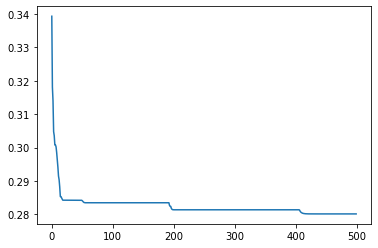

In [6]:
plt.plot(range(MAX_ITER), bests)

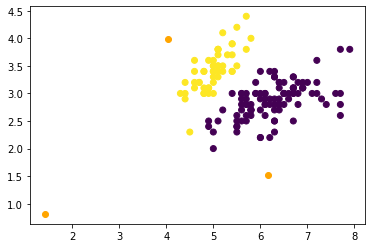

In [7]:
plt.scatter(data[:, 0], data[:, 1], c = clusters)
centroids_np = np.array(globalBestParticle.centroids)
plt.scatter(centroids_np[:, 0], centroids_np[:, 1], color='orange')
#plt.savefig("pso_db_2d_outlier.svg")

In [12]:
kmean = KMeans(2, init='random').fit(data)

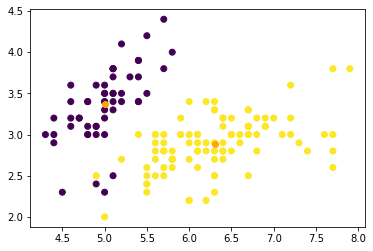

In [13]:
plt.scatter(data[:, 0], data[:, 1], c=kmean.labels_)
plt.scatter(kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1], color='orange')
#plt.save("kmeans_db_2d_outlier.svg")

In [14]:
print(globalBestParticle.objective(data.tolist(), kmean.labels_))

0.4042928371730438


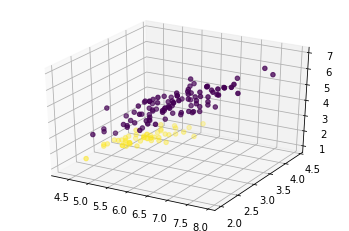

In [11]:
ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:, 2], c=clusters);